# Testing an approach to timing and parse probabilities

One of the main goals of my dissertation is a quantitative theory of why different sentences are processed at different speeds in the SOSP framework. I also want to understand why SOSP produces the distribution of parses it does for comparison with human data. Here, I propose a pretty naive approach to those two problems that partially succeeds at least *qualitatively*.

### Processing speeds
For noiseless dynamical systems, $1 /\vert\lambda\vert$, where $\lambda$ is the smallest-magnitude eigenvalue of a stable fixed point, gives the characteristic time scale of that fixed point (Strogatz, 1994). Attractors with higher-magnitude $\lambda$s pull the system faster than attractors with smaller $\lambda$s. For SOSP, then, we should expect differences in reading times between two alternative parses if their characteristic time scales are different. With a noisy system, this property should still hold as long as the magnitude of the noise is small enough (if the eigenvalues of the noise matrix are smaller in magnitude than those of the linearized noiseless dynamics?).

### Probability distribution over parses
After reading a word, the state of an SOSP parser will be somewhere between attractors, likely near a separatrix between two or more attractor basins. The system will then settle toward an attractor until it gets sufficiently close. To estimate analytically which attractors are most likely, we decide in advance which attractors are most relevant, e.g., the nearest $n$ parses. We then estimate the probability of being in each parse by integrating the stationary probability distribution over a small area containing the harmony peak for that parse. The relative probability of each parse is then just this integral divided by the sum of all relevant integrals. (Below, I don't do this integration because it was providing very similar results in testing. Instead, I just calculate the probabilty of being at a particular harmony peak and then divide it by the sum of all such relevant probabilities.)

***
## A simple test system

Here, I'll consider a 1D example to test this approach. The noiseless harmony function is (Muezzinoglu & Zurada, 2006):
$$
H(x) = \sum_{i \in {0, 1}} h_i\phi_i(x) = h_0\exp\left(-\frac{x^2}{\gamma} \right) + h_1\exp\left(-\frac{(x-1)^2}{\gamma} \right)
$$
The $h_i$ are the local harmony values for each peak (here, $h_0 = 1.0$ and $h_1 = 0.5$), and $\gamma = 0.15$ is a parameter that sets the widths of the peaks.

The dynamics of the system is given by the gradient of the harmony function:
$$
\dot{x} = \nabla H(x) = -\frac{2 h_0}{\gamma} x \exp\left(-\frac{x^2}{\gamma} \right) - \frac{2 h_1}{\gamma} (x - 1) \exp\left(-\frac{(x-1)^2}{\gamma} \right)
$$

The linearization (for getting the characteristic time scale) is tedious to calculate by hand, so I'll let SymPy do it for me below.

With a Gaussian noise term $dW$ (variance = $D$) added, the final stochastic differential equation (a Langevin equation) is:
$$
\dot{x} = \nabla H(x) + \sqrt{2D}dW
$$

The associated Fokker-Planck equation is (Gardiner, 1985):
$$
\frac{\partial P(x, t)}{\partial t} = -\frac{\partial \nabla H}{\partial x} P(x, t) + \frac{\partial^2 D P(x, t)}{\partial x^2}
$$
which has the stationary solution:
$$
P_s(x) = \mathcal{N}^{-1} \exp\left(H(x) / D \right)
$$
where $\mathcal{N}$ is a normalization constant that ensures $\int_{-\infty}^{\infty} P_s d\mathbf{x} = 1$. Here, I use $\mathcal{N} = \int_{-\infty}^{\infty} \exp\left(H(\mathbf{x})/D\right)d\mathbf{x}$.

***
Now, let's turn to SymPy to start analyzing this system.

In [1]:
from sympy import *
init_printing()  # Makes the outputs look nicer
from IPython.display import display

x, h0, h1, gamma, D = symbols('x h0 h1 gamma D')  # make these formal symbols for SymPy to manipulate
h0 = 1.0
h1 = 0.5
D = 0.1
gamma = 0.15

H = h0*exp(-x**2 / gamma) + h1*exp(-(x-1)**2 / gamma)  # defining the harmony function
#print('H =')
#display(H)

dxdt = diff(H, x)  # taking the gradient of H wrt. x
#print('\ndx/dt = ')
#display(dxdt)

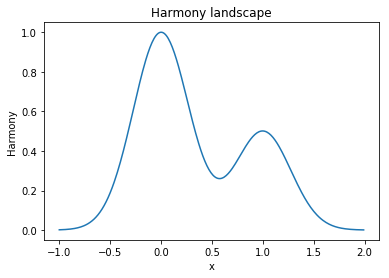

In [2]:
# Looking at the harmony landscape
import numpy as np
import matplotlib.pyplot as plt

Hnum = lambdify(x, H)  # Create a Numpy function out of the symbolic harmony function
xrange = np.arange(-1., 2, 0.01)
harmony = np.zeros(xrange.shape)
for i in range(len(xrange)):
    harmony[i] = Hnum(xrange[i])
plt.plot(xrange, harmony)
plt.title('Harmony landscape')
plt.ylabel('Harmony')
plt.xlabel('x')
plt.show()

Next, we set up the stationary probability distribution and find its normalization:

In [3]:
# The unnormalized stationary probability distribution, with values substituted in for the various parameters
Punnorm = exp(H / D) - 1  # Need to subtract 1 so that the curve sits on the x-axis; Check with Till!
# Finding the normalization
normalization = Integral(Punnorm, (x, -oo, oo)).evalf()  # Takes about a minute to calculate
#print(normalization)
Ps = (1 / normalization) * Punnorm
Ps

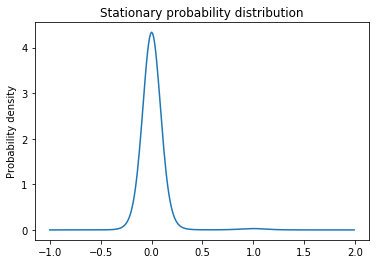

In [4]:
# Now plotting the stationary probability distribution Ps
Psnum = lambdify(x, Ps)
probs = np.zeros(xrange.shape)
for i in range(len(xrange)):
    probs[i] = Psnum(xrange[i])
plt.plot(xrange, probs)
plt.title('Stationary probability distribution')
plt.ylabel('Probability density')
plt.show()

This is where the problem is. Pilot testing the dynamical system below runs fine on its own as long as D <= about 0.1; it settles in about the right proportions and at about the right speeds. But until D >= about 0.5, there is almost no probability around x1. This is due to the fact that for small noise levels, we're dividing the harmony by a small number (making it really big) and then exponentiating it, which just exaggerates the difference in harmony height between x0 and x1 even more. But as far as I can tell, the equation above for the stationary probability distribution ($\exp(H(\mathbf{x}) / D$) is correct (Gardiner, 1985, p. 146-147; Haken, 1983, p.167). The system is obviously (see below) not behaving like this stationary probability distribution suggests, so I'm not sure what to do...

In [5]:
# With this harmony function, the fixed points aren't exactly at 0 and 1; they get pulled together a 
# bit due to the summing of their Gaussians. So we first find the zeros of dxdt:
x0 = nsolve(dxdt, x, 0)  # using a numeric solver
x1 = nsolve(dxdt, x, 1)
print('Zeros of H(x):\n{}\n{}'.format(*[x0, x1]))

# Finding harmony minimum between x0 and x1
xmid = nsolve(dxdt, x, 0.5)
print('Local harmony minimum: x = {}'.format(xmid))

Zeros of H(x):
0.000641370143190638
0.997370855668460
Local harmony minimum: x = 0.574505301213735


In [6]:
# Now we can calculate the ratio of the probabilities of x0 to x1 (Cho et al., 2018)
ratio = Ps.subs(x, x0) / Ps.subs(x, x1)
ratio

In [7]:
# Calculating the relative probabilities of each attractor:
p0 = Ps.subs(x, x0) / (Ps.subs(x, x0) + Ps.subs(x, x1))
p1 = Ps.subs(x, x1) / (Ps.subs(x, x0) + Ps.subs(x, x1))
print('Relative probabilities:\nx0 = {}\nx1 = {}'.format(*[p0, p1]))
print('Difference in harmony: H(x0) - H(x1) = {}'.format(H.subs(x, x0) - H.subs(x, x1)))

Relative probabilities:
x0 = 0.993307610307566
x1 = 0.00669238969243383
Difference in harmony: H(x0) - H(x1) = 0.499344101698450


In [8]:
# From Gardiner (1985, p. 346, eq. 9.1.21)
lin = dxdt.diff(x)  # linearization of the dynamics/second derivative of the harmony function
# this approximates how far off the numerically-found location xmid is from the actual midpoint
# Because it's positive, that means we're starting just to the left of the midpoint
err = 0.001
pan1 = 0.5*(1 - erf(err * sqrt(lin.subs(x, xmid) / D)))
pan0 = 1 - pan1
print('Analytical relative probabilities:\nx0 = {}\nx1 = {}'.format(*[pan0, pan1]))

Analytical relative probabilities:
x0 = 0.504995964379565
x1 = 0.495004035620435


So, this approach predicts that an SOSP parser using this harmony landscape should approach the attractor at x=0 about XX% of the time and x=1 YY% of the time, if it starts about halfway between them.

Now, we can look at how fast the system should approach each attractor. To do this, we simply find the lowest-magnitude eigenvalue $\lambda$ of the linearized dynamics at each fixed point. Then, $1/\vert\lambda\vert$ gives the characteristic time scale of that attractor.

In [9]:
char0 = abs(lin.subs(x, x0))
char1 = abs(lin.subs(x, x1))
print('Characteristic time scales:\nx0 = {}\nx1 = {}'.format(*[1/char0, 1/char1]))
print('\nEigenvalues:\nx0 = {}\nx1 = {}'.format(*[char0, char1]))

Characteristic time scales:
x0 = 0.0755981736349579
x1 = 0.155032954242941

Eigenvalues:
x0 = 13.2278327890395
x1 = 6.45024153015218


As we can see, the characteristic time scale for the attractor near x = 0 is faster (closer to zero) than that of the attractor near x = 1. Thus, we expect faster processing times when the system "chooses" x0 compared to x1. Now we can test these predictions using simulations of the system.

In [10]:
# A different naive approach based on Strogatz p. 98
# Have to put them just off of the fixed points, otherwise the times diverge to infinity
Tx0 = Integral(1 / dxdt, (x, xmid-0.01, x0+0.01)).evalf()
Tx1 = Integral(1 / dxdt, (x, xmid+0.01, x1-0.01)).evalf()
#display(Tx0, Tx1)
print('Time to settle:\nx0: {}\nx1: {}'.format(Tx0, Tx1))

Time to settle:
x0: 0.690052210264754
x1: 0.967548992459501


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

centers = np.array([0, 1])
harmonies = np.array([2., 1])
#gamma = 0.15
ndim = 1
#noisemag = 0.1  # D above
maxsteps = 1000
tau = 0.01
xinit = np.float(xmid)  # starting at the midpoint between the two attractors


# Defining phi function
def phi(x, center, gamma):
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


# A function for updating the state of the system according to the negative
# gradient of the harmony function
def step_dyn(x, centers, harmonies, gamma):
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


# Are we close to an attractor?
def not_close(x, centers, tol):
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros(maxsteps)
nruns = 5000
data = np.zeros((nruns, 2))  # first column for which attr, second for time

for run in range(nruns):
    if run % 500 == 0:
        print('[{}] '.format(run), end='')
    xhist[0] = xinit
    noise = np.random.normal(0, 1, xhist.shape)
    t = 0
    while t < maxsteps-1:
        if not_close(xhist[t], centers, 0.1):
            xhist[t+1] = (xhist[t] + tau*step_dyn(xhist[t], centers, harmonies, gamma)
                      + np.sqrt(2*D*tau)*noise[t])
            t += 1
        else:
            break
    data[run, :] = [np.round(xhist[t]), t]

if nruns == 1:
    plt.plot(xhist)
    plt.show()


[0] [500] [1000] [1500] [2000] [2500] [3000] [3500] [4000] [4500] 

In [14]:
# Now looking at the data
mean0 = np.mean(data[np.where(data[:,0] == 0), 1])
mean1 = np.mean(data[np.where(data[:,0] == 1), 1])
ratio_emp = data[np.where(data[:,0] == 0), 0].shape[1] / data[np.where(data[:,0] == 1), 0].shape[1]
print('\nProportion of x0 runs:\t\t{} (Gardiner predicted: {})'.format(1-np.mean(data[:, 0]), pan0))
print('Ratio of x0 runs to x1 runs:\t{} (st. prob. distr. predicted: {})'.format(ratio_emp, ratio))
print('\nMean RT for x0:\t\t\t{}'.format(mean0))
print('Mean RT for x1:\t\t\t{}'.format(mean1))
print('Ratio of x1 to x0 RTs:\t\t{} (Char. time scales predicted: {})'.format(mean1 / mean0, (1/char1) / (1/char0)))
print('Ratio of x1 to x0 RTs:\t\t{} (Strogatz predicted: {})'.format(mean1 / mean0, Tx1 / Tx0))



Proportion of x0 runs:		0.5408 (Gardiner predicted: 0.504995964379565)
Ratio of x0 runs to x1 runs:	1.1777003484320558 (st. prob. distr. predicted: 148.423456486786)

Mean RT for x0:			19.72596153846154
Mean RT for x1:			20.114547038327526
Ratio of x1 to x0 RTs:		1.0196991918040763 (Char. time scales predicted: 2.05074999551644)
Ratio of x1 to x0 RTs:		1.0196991918040763 (Strogatz predicted: 1.40213882089919)


## Discussion
The simulations of the simple SOSP system behave as we would expect: the system settles faster and more often to the higher-harmony attractor (x0) than to x1. This general pattern is predicted *qualitatively* by the characteristic time-scale analysis and by the splitting probability analysis from Gardiner (which only applies in 1D). The qualitative fit is encouraging, but the whole point of this is *quantitative* predictions.

### What kinda works
1. Using the characteristic time scales to predict reading times at least gets the ordering (faster/slower) correct, although I'm still not sure how to compare these to human or simulation reading times. Ratios don't seem to work, so what's the best mapping?
2. The simple integration approach for settling times does reasonably well as long as I don't set the start and end points of the integration to be exactly at the fixed points.
3. The Gardiner approach to splitting probabilites provides reasonable predictions for the actual distribution over final states, although (major caveat!) I arbitrarily guessed at the difference between the numerical calculation of the harmony minimum and its actual location.

### What doesn't really work
1. ~~Going from the harmony function to the stationary probability distribution can't be right because it doesn't reflect the actual behavior of the system. If it did, the system would settle to x0 almost every time.~~ The stationary probability distribution is only valid for $t \rightarrow \infty$, so what it predicts is probably reasonable if we let the system settle for a very long time.
2. The splitting probabilities equation from Gardiner is only valid for 1D, and the method I tried for getting the ratio of x0 to x1 parses and the relative probabilities didn't work because they're based on the stationary probability distribution.
